# **Intel Image Classification**



<p><img style="float:right; margin:20px; padding:20px; max-height:250px" src="https://images.unsplash.com/photo-1541328088513-80ed7704b8f2?q=80&w=3542&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"></p>
<p style="text-align:justify;">

    



**Задача:**

* дообучить сеть на новом датасете для классификации

Будет использован датасет фотографий Intel Image Classification (https://www.kaggle.com/puneet6060/intel-image-classification) природы.
</p>

# **Импорт библиотек 📚**

In [ ]:
!apt-get install git-lfs
!git lfs install

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Git LFS initialized.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score

## **Загрузка датасета 💽**


In [ ]:
!git clone https://github.com/vonexel/Data-Science-Projects.git
%cd Data-Science-Projects/Intel Image Classification using CNN


!git lfs pull
!unzip -q "Intel Image Classification.zip" -d dataset

Cloning into 'Data-Science-Projects'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 4), reused 23 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 1.85 MiB | 2.49 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/Data-Science-Projects/Intel Image Classification using CNN


In [ ]:
!ls dataset

seg_pred  seg_test  seg_train


In [ ]:
! ls dataset/seg_train/seg_train

buildings  forest  glacier  mountain  sea  street


In [ ]:
! ls dataset/seg_test/seg_test

buildings  forest  glacier  mountain  sea  street


Объявим трансформации для тренировочного и тестового набора данных:

*   перевод изображения в тензор;
*   нормализация с mean=[0.485, 0.456, 0.406] и std=[0.229, 0.224, 0.225].


In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,
                               0.456,
                               0.406],
                         std=[0.229,
                              0.224,
                              0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,
                               0.456,
                               0.406],
                         std=[0.229,
                              0.224,
                              0.225])
])

И теперь объявим датасеты:

In [ ]:
train_data = datasets.ImageFolder("dataset/seg_train/seg_train", transform=transform_train)
test_data = datasets.ImageFolder("dataset/seg_test/seg_test", transform=transform_val)

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: dataset/seg_train/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Объявим даталоадеры:
* для тренировочного даталоадера перемешаем данные, для тестового - нет;
* установим оптимальный размер батча.

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

Посмотрим на примеры изображений из датасета, и заодно проверим, что даталоадеры корректно объявлены:

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [ ]:
images.shape, labels.shape

(torch.Size([32, 3, 150, 150]), torch.Size([32]))

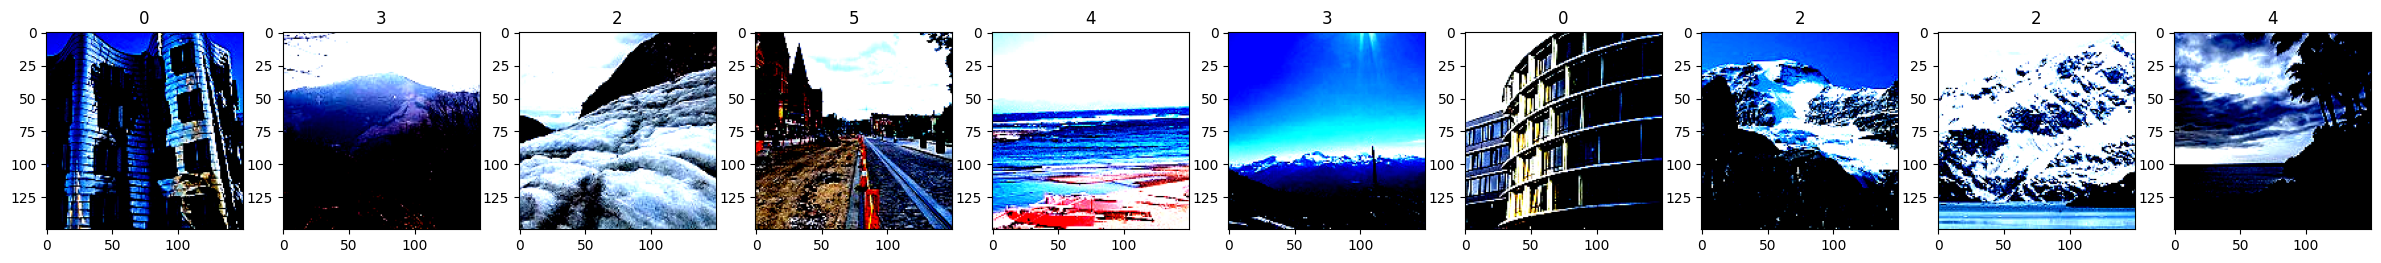

In [ ]:
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
      axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
      axes[i].set_title(labels[i].numpy())
    plt.show();

show_imgs(images, labels)

# **Обучение сверточной сети** 🧙‍♂️|🛠️

Сеть ConvNet (3 Conv-слоя, 2 MaxPool-слоя):


Сверточные сети (CNN), опирающиеся на механизм реагирования на определенные паттерны – свертку, позволяющую каждому следующему слою выделять все более абстрактные, высокоуровневые признаки на изображениях. Нейросеть использует фильтр (convolution layer), уменьшение размерности (pooling) и функции активации (activation function) для сканирования картинки и извлечения локальных признаков, таких как края, детали и текстуры, а также могут быть точно обучены к распознаванию различных поз и положений объекта детекции в двумерном пространстве:


* Сам процесс следования по сверткам подразумевает операцию поэтапного умножения
и суммирования каждой позиции для объединения и составления карты признаков. Данная процедура циклична вплоть до обработки всех входных данных, по итогу, образуя новую матрицу, подчеркивающую наличие признака, для обнаружения которого и предназначено ядро. Помимо этого, параметр stride (размерность шага ядра) и padding (добавление 0, в области вблизи входного сигнала), оказывают непосредственное влияние на регулирование размера выходного сигнала и фиксации информации о краях изображения.


* Для интенсификации способности интерпретации сетью абстрактных и комплексных зависимостей, в одном слое conv, типично задействование пары ядер для одновременного обнаружения нескольких признаков. После прохождения нескольких слоев свертки и пулинга, полученные признаки объединяются между собой, поступая в полносвязные слои: классификаторы или регрессоры (в зависимости от задачи), выдающие финальные предсказания.


Сверточные нейросети анализируют изображения не целиком, а по частям, начиная с минимальных кусочков, постепенно распознавая более сложные формы и паттерны в рамках окна – локального фильтра, перемещаемого вдоль изображения попиксельно, начиная сдвиг вдоль горизонтальной и вертикальной осей с левого верхнего угла, вплоть до правого нижнего.


Также, необходимо отметить, что данная архитектура инвариантна относительно небольших сдвигов благодаря слою maxpool, в котором избирается максимальное значение в рамках ядра пуллинга, чье положение способно быть различным, но неустойчива касательно вращения. Для того, чтобы обойти данное ограничение, обращаются к аугментации данных, поворачивая обучающие данные случайным образом.


Пример архитектуры модели представлен на рисунке:

<p><img style="float:right; margin:20px; padding:20px; max-height:250px" src="https://www.mdpi.com/applsci/applsci-13-03380/article_deploy/html/images/applsci-13-03380-g001.png"></p>


Построим сверточную нейронную сеть, обучим ее и посчитаем метрику accuracy на тестовой выборке.

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 5, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(5, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(4, 3, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.flatten = Flatten()
        self.fc = nn.Sequential(
            nn.Linear(37*37*3, 256),
            nn.ReLU(),
            nn.Linear(256, 6),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

Функция обучения использует:
* оптимизатор Adam;
* learning rate  = 0.0001;
* функцию потерь - CrossEntropyLoss
* 20 эпох.


В процессе обучения модель проходит цикл по батчам данных, вычисляет предсказания, обновляет веса через обратное распространение ошибки, а также логирует средние потери и точность как для отдельных батчей (каждые 10 шагов), так и для полных эпох. После завершения всех эпох функция выводит итоговую точность модели на тренировочных данных и возвращает обученную сеть, обеспечивая мониторинг ключевых показателей через проект в Weights & Biases.

In [ ]:
def train(net):
    wandb.init(project="Intel Image Classification Vailla-ConvNet vs AlexNet", name = "{net}", config=wandb.config)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=wandb.config.lr)
    total_steps = 0

    for epoch in range(wandb.config.epochs):
        running_loss = 0.0
        epoch_correct = 0
        epoch_total = 0

        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            optimizer.zero_grad()

            y_pred = net(X_batch)
            loss = loss_fn(y_pred, y_batch)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            batch_correct = (predicted == y_batch).sum().item()
            epoch_correct += batch_correct
            epoch_total += y_batch.size(0)
            if batch_idx % 10 == 9:
                avg_loss = running_loss / 10
                batch_acc = batch_correct / y_batch.size(0)

                wandb.log({
                    "batch_loss": avg_loss,
                    "batch_acc": batch_acc,
                    "epoch": epoch,
                    "step": total_steps
                })
                running_loss = 0.0
                total_steps += 10
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = epoch_correct / epoch_total

        wandb.log({
            "epoch_loss": epoch_loss,
            "epoch_acc": epoch_acc,
            "epoch": epoch,
            "step": total_steps
        })

        print(f'Epoch {epoch+1}/{wandb.config.epochs} | '
              f'Loss: {epoch_loss:.4f} | '
              f'Accuracy: {epoch_acc:.4f}')

    print('Обучение закончено')
    return net


net = ConvNet()


config = {
    "epochs": 20,
    "batch_size": 28,
    "lr": 0.0001,
}

# **Запуск эксперимента: Vanilla CNN**

In [ ]:
wandb.login()
with wandb.init(project="Intel Image Classification Vailla-ConvNet vs AlexNet", config=config):
    net = train(net)

Epoch 1/20 | Loss: 0.0299 | Accuracy: 0.4618
Epoch 2/20 | Loss: 0.0283 | Accuracy: 0.6004
Epoch 3/20 | Loss: 0.0293 | Accuracy: 0.6295
Epoch 4/20 | Loss: 0.0283 | Accuracy: 0.6486
Epoch 5/20 | Loss: 0.0281 | Accuracy: 0.6576
Epoch 6/20 | Loss: 0.0284 | Accuracy: 0.6747
Epoch 7/20 | Loss: 0.0277 | Accuracy: 0.6791
Epoch 8/20 | Loss: 0.0271 | Accuracy: 0.6866
Epoch 9/20 | Loss: 0.0281 | Accuracy: 0.6952
Epoch 10/20 | Loss: 0.0271 | Accuracy: 0.6981
Epoch 11/20 | Loss: 0.0271 | Accuracy: 0.7078
Epoch 12/20 | Loss: 0.0269 | Accuracy: 0.7124
Epoch 13/20 | Loss: 0.0273 | Accuracy: 0.7169
Epoch 14/20 | Loss: 0.0275 | Accuracy: 0.7254
Epoch 15/20 | Loss: 0.0268 | Accuracy: 0.7313
Epoch 16/20 | Loss: 0.0262 | Accuracy: 0.7416
Epoch 17/20 | Loss: 0.0263 | Accuracy: 0.7437
Epoch 18/20 | Loss: 0.0265 | Accuracy: 0.7518
Epoch 19/20 | Loss: 0.0263 | Accuracy: 0.7584
Epoch 20/20 | Loss: 0.0260 | Accuracy: 0.7608
Обучение закончено


batch_acc,▁▂▂▂▂▆▅▃▃▂▇▅▃▅▅▆▇▅▇▅▇▅▅▄▃▆▄▅▄▄▇▇▇▇▅█▄▄▅▄
batch_loss,█▅▄▄▄▃▂▃▂▂▂▂▁▂▂▂▂▃▂▂▂▂▁▁▂▂▁▂▂▂▂▂▂▂▁▁▂▁▁▁
epoch,▁▁▁▁▁▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
epoch_acc,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇█████
epoch_loss,█▅▇▅▅▅▄▃▅▃▃▃▃▄▂▁▂▂▂▁
step,▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█
batch_acc,0.6875
batch_loss,1.30301
epoch,19
epoch_acc,0.7608
epoch_loss,0.02596


Посчитаем accuracy на test:

In [ ]:
test_dataiter = iter(test_loader)
images, labels = next(test_dataiter)

In [ ]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images).detach().numpy(), axis=1))

0.75

Accuracy на train составило (0.7608), а на test - (0.75), что свидетельствует о том, что сеть не переобучилась, так как разница между точностями на обучающей и тестовой выборках минимальна. Низкое значение batch_loss (1.30301) и особенно epoch_loss (0.02596) подтверждают, что модель хорошо обучилась на тренировочных данных.

Точность 0.75 на тестовой выборке указывает на то, что сеть распознаёт изображения с приемлемым качеством, но есть возможность для улучшений:

* увеличить число эпох;
* увеличение числа фильтров для извлечения большего ччисла признаков;
* добавить дополнительный сверточный блок (Conv2d → ReLU → MaxPool2d) для более глубокого анализа признаков;
* добавить слой nn.BatchNorm2d после каждого сверточного слоя для стабилизации обучения и ускорения сходимости;
* добавить Dropoutв полносвязные слои для предотвращения переобучения.

## **Дообучение AlexNet**

Теперь дообучим сеть, предобученную на ImageNet, на текущем датасете:


AlexNet — это глубокая сверточная нейронная сеть (CNN), разработанная Алеком Крижевским, Ильей Сацкевером и Джеффри Хинтоном в 2012 году. Она стала прорывом в области компьютерного зрения, выиграв конкурс ImageNet Large Scale Visual Recognition Challenge (ILSVRC-2012) с топ-5 ошибкой 15.3%, что на 10.8% лучше предыдущих моделей. Эта архитектура заложила основы современных CNN, внедрив ключевые инновации, такие как использование ReLU, GPU и методов регуляризации.



AlexNet состоит из 8 слоев:


5 сверточных слоев с фильтрами разного размера:

* Conv1: 11×11, 96 фильтров, stride=4;

* Conv2: 5×5, 256 фильтров;

* Conv3-Conv5: 3×3, 384-256 фильтров;

* 3 полносвязных слоя (FC) с 4096, 4096 и 1000 нейронами соответственно (последний для классификации ImageNet).



Дополнительные слои:


* Max-pooling с перекрывающимися окнами 3×3 (stride=2) для уменьшения размерности;

* Local Response Normalization (LRN) после первых двух сверток для улучшения контрастности признаков.



Ключевые особенности:
* ReLU вместо сигмоидальных функций (исправляет проблему с затухающими градиентами);

* Перекрывающийся пулинг (уменьшает размерность карт признаков, сохраняя важные детали)


Архитектура сети представлена на рисунке:
<p><img style="float:right; margin:20px; padding:20px; max-height:250px" src="https://www.mdpi.com/sensors/sensors-19-05218/article_deploy/html/images/sensors-19-05218-g004.png"></p>



Список сетей, предобученных на ImageNet, которые есть в библиотеке PyTorch: https://pytorch.org/docs/stable/torchvision/models.html

In [ ]:
AlexNet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 178MB/s]


In [ ]:
AlexNet.parameters

<bound method Module.parameters of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=4096, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  )
)>

Реализуем класс New_AlexNet на основе AlexNet, у которой заменили последний слой. Заморозим все слои, кроме слоев классификатора (всех линейных слоев):

In [ ]:
class New_AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.alexnet = models.alexnet(pretrained=True)
        self.alexnet.classifier[6] = nn.Linear(4096, num_classes)
        for param in self.alexnet.parameters():
            param.requires_grad = False
        for param in self.alexnet.classifier.parameters():
            param.requires_grad = True


    def forward(self, x):
        return self.alexnet(x)

Укажем иную конфигурацию гиперпараметров для оптимизации скорости обучения, т.к. сеть предобучена на большом объеме данных:

In [ ]:
config_alex_net = {
    "epochs": 5,
    "batch_size": 28,
    "lr": 0.0001,
}

# **Запуск эксперимента: New_AlexNet**

In [ ]:
net_v1 = New_AlexNet()
with wandb.init(project="Intel Image Classification Vailla-ConvNet vs AlexNet", config=config_alex_net):
    net_v1 = train(net_v1)

Epoch 1/5 | Loss: 0.0071 | Accuracy: 0.8588
Epoch 2/5 | Loss: 0.0048 | Accuracy: 0.9077
Epoch 3/5 | Loss: 0.0042 | Accuracy: 0.9325
Epoch 4/5 | Loss: 0.0020 | Accuracy: 0.9441
Epoch 5/5 | Loss: 0.0024 | Accuracy: 0.9555
Обучение закончено


batch_acc,▁▂▃▅▁▇▅▅▅▅▆▆▂▆▃▃▇▂▃▆▇▆█▇▃▃▆▇▅▇▇▇▇▇▇▇▅▆▆▆
batch_loss,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆████████
epoch_acc,▁▅▆▇█
epoch_loss,█▅▄▁▂
step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
batch_acc,0.96875
batch_loss,0.10219
epoch,4
epoch_acc,0.95554
epoch_loss,0.00238


И посмотрим на скор на тесте:

In [ ]:
test_dataiter = iter(test_loader)
images, labels = next(test_dataiter)

In [ ]:
accuracy_score(labels.numpy(), np.argmax(net_v1.forward(images).detach().numpy(), axis=1))

0.84375

**Задание 3.2:**

Напишите класс New_AlexNet на основе AlexNet, у которой заменили последний слой(как в задании выше) Заморозьте все слои, кроме **двух последних** слоев классификатора

In [ ]:
class New_AlexNet_v2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.alexnet = models.alexnet(pretrained=True)
        in_features = self.alexnet.classifier[6].in_features
        self.alexnet.classifier[6] = nn.Linear(in_features, num_classes)
        for param in self.alexnet.parameters():
            param.requires_grad = False
        for param in self.alexnet.classifier[4].parameters():
            param.requires_grad = True
        for param in self.alexnet.classifier[6].parameters():
            param.requires_grad = True


    def forward(self, x):
        return self.alexnet(x)

In [ ]:
net_v2 = New_AlexNet_v2()
with wandb.init(project="Intel Image Classification Vailla-ConvNet vs AlexNet", config=config_alex_net):
    net_v2 = train(net_v2)

Epoch 1/5 | Loss: 0.0076 | Accuracy: 0.8523
Epoch 2/5 | Loss: 0.0056 | Accuracy: 0.9012
Epoch 3/5 | Loss: 0.0048 | Accuracy: 0.9196
Epoch 4/5 | Loss: 0.0038 | Accuracy: 0.9304
Epoch 5/5 | Loss: 0.0034 | Accuracy: 0.9426
Обучение закончено


batch_acc,▄▅▁▅▅▄▅▅▅▆▆▅▅▄▇▆▇▅▅▆█▆▆▅▆▅▅▆▃█▅██▅▅▅▇█▇▆
batch_loss,█▃▂▂▂▃▂▂▂▂▁▁▁▂▂▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆██████████
epoch_acc,▁▅▆▇█
epoch_loss,█▅▃▂▁
step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
batch_acc,0.9375
batch_loss,0.13423
epoch,4
epoch_acc,0.94257
epoch_loss,0.0034


И посмотрим на скор на тесте:

In [ ]:
test_dataiter = iter(test_loader)
images, labels = next(test_dataiter)

In [ ]:
accuracy_score(labels.numpy(), np.argmax(net_v2.forward(images).detach().numpy(), axis=1))

0.78125

# **Вывод:**



[Результаты обучения на W&B](https://wandb.ai/vonexel0/Intel%20Image%20Classification%20Vailla-ConvNet%20vs%20AlexNet)




* **Vanilla CNN**: **75** на тесте.

* **New_AlexNet**: **84.375** на тесте.

* **New_AlexNet_v2**: **78.125** на тесте.



New_AlexNet (предобученная на ImageNet) продемонстрировала лучший результат (84.375% против 75% у Vanilla CNN), несмотря на меньшее число эпох (5 к 20). Это ожидаемо, так как предобученные модели эффективно извлекают признаки, даже если их свёрточные слои заморожены. Классы, связанные с природой (растения, животные, ландшафты), хорошо представлены в ImageNet, что делает AlexNet более эффективной для данной задачи.


При дообучении только последнего слоя модель сохраняет общие признаки из ImageNet, адаптируя лишь финальную классификацию под целевую задачу. Это снижает риск переобучения. Разморозка двух слоёв увеличивает число обучаемых параметров, что требует больше данных для корректной настройки. На малом датасете это приводит к переобучению (train accuracy 94.25%, test 78.125%).